In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [101]:
train_data = pd.read_csv('HistoricalPrices-3.csv')
train_prices = train_data[' Close'].values.reshape(-1, 1)

# Load testing data from another CSV file
test_data = pd.read_csv('NIFTY 100-16-07-2024-to-20-08-2024.csv')
test_prices = test_data['Close '].values.reshape(-1, 1)

In [116]:
# Normalize the data
scaler = MinMaxScaler()
train_prices_scaled = scaler.fit_transform(train_prices)
test_prices_scaled = scaler.transform(test_prices)

# Prepare the data for LSTM training
window_size = 1
X_train, y_train = [], []
X_test, y_test = [], []

# Create training data sequences
for i in range(len(train_prices_scaled) - window_size):
    X_train.append(train_prices_scaled[i:i + window_size])
    y_train.append(train_prices_scaled[i + window_size])

# Create testing data sequences
for i in range(len(test_prices_scaled) - window_size):
    X_test.append(test_prices_scaled[i:i + window_size])
    y_test.append(test_prices_scaled[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the scaled predictions to get actual prices
train_predictions_actual = scaler.inverse_transform(train_predictions)
test_predictions_actual = scaler.inverse_transform(test_predictions)

# Calculate returns and risks
test_returns = np.diff(test_predictions_actual, axis=0) / test_predictions_actual[:-1]
average_return = np.mean(test_returns)
total_return = float((test_predictions_actual[-1] - test_predictions_actual[0]) / test_predictions_actual[0])
risk = np.std(test_returns)

# Print return and risk metrics
print("For a trading strategy using LSTM, we get-")
print(f"Average Return: {average_return:.4f}")
print(f"Total Return: {total_return:.4f}")
print(f"Risk (Standard Deviation of Returns): {risk:.4f}")
print("")

Epoch 1/50
73/73 [==============================] - 2s 2ms/step - loss: 0.1514
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 0.0510
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 8.8056e-04
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 5.1418e-04
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 4.3481e-04
Epoch 11/50
73/73 [==============================] - 0s 3ms/step - loss: 4.1776e-04
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 4.1029e-04
Epoch 13/50
73/73 [==========

In [118]:
initial_investment = 10000
investment_value = initial_investment

lstm_profits = []

for i in range(1, len(test_predictions_actual)):
    change = (test_predictions_actual[i] - test_predictions_actual[i - 1]) / test_predictions_actual[i - 1]
    investment_value *= (1 + change)
    profit = investment_value-initial_investment
    lstm_profits.append(profit)

# Accumulate profits over time
accumulated_lstm_profits = []
current_accumulated_profit = initial_investment
for profit in lstm_profits:
    current_accumulated_profit += profit
    # print(current_accumulated_profit)
    accumulated_lstm_profits.append(current_accumulated_profit[0])

[10012.491, 10075.396, 10210.483, 10221.045, 10194.745, 10184.125, 10229.965, 10219.227, 10216.762, 10272.915, 10317.477, 10235.909, 10073.923, 9993.331, 9956.008, 9904.233, 9886.408, 9814.305, 9680.688, 9530.436, 9396.259, 9206.993]


In [119]:
# Normalize the data
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()
train_data_normalized = train_scaler.fit_transform(train_data.iloc[:, 4].values.reshape(-1, 1))
test_data_normalized = test_scaler.fit_transform(test_data.iloc[:, 4].values.reshape(-1, 1))

# Define the state function
def get_state(state_index, data):
    lookback_window = 5  # Number of previous time steps to consider
    start_index = max(0, state_index - lookback_window)
    end_index = state_index + 1
    state = data[start_index:end_index].flatten()
    return state

# Define the actions
num_actions = 2  # Buy (1) or Hold (0)
action_mapping = {0: 'Hold', 1: 'Buy'}

# Create a Q-table, which is a table that stores the Q-values for each state-action pair.
num_train_states = train_data_normalized.shape[0]
num_test_states = test_data_normalized.shape[0]
q_table = torch.zeros((num_train_states, num_actions))
# Initialize the Q-table with random values.
nn.init.xavier_uniform_(q_table)

# Define the epsilon-greedy policy
def epsilon_greedy_policy(state, q_table, epsilon):
    if random.random() < epsilon:
        action = random.randint(0, num_actions - 1)
    else:
        action = torch.argmax(q_table[state])
    return action

# Define the Bellman equation
def bellman_equation(state, action, reward, next_state_index, q_table):
    if next_state_index < num_train_states:
        next_state = torch.tensor([next_state_index])
        target = reward + gamma * torch.max(q_table[next_state])
    else:
        target = reward
    q_table[state, action] = target

# Training phase
num_epochs = 30
epsilon = 1.0
gamma = 0.98
replay_buffer = []
batch_size = 32
target_update_freq = 10
target_q_table = q_table.clone()

for i in range(num_epochs):
    for state in range(num_train_states - 1):
        current_state = get_state(state, train_data_normalized)
        action = epsilon_greedy_policy(state, q_table, epsilon)
        reward = train_data_normalized[state + 1].item()  # Convert tensor to a Python scalar
        next_state_index = state + 1
        bellman_equation(state, action, reward, next_state_index, q_table)

        # Store experience in replay buffer
        replay_buffer.append((current_state, action, reward, next_state_index))

        # Perform experience replay
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            for batch_current_state, batch_action, batch_reward, batch_next_state_index in batch:
                bellman_equation(batch_current_state, batch_action, batch_reward, batch_next_state_index, q_table)

    # Update target Q-table
    if i % target_update_freq == 0:
        target_q_table = q_table.clone()

    # Decay epsilon
    epsilon *= 0.70

# Testing phase


In [127]:
shares = 0
portfolio = 10000
profits = []
returns = []
risks = []
for state in range(num_test_states - 1):
    current_state = get_state(state, test_prices_scaled)
    action = torch.argmax(q_table[state])
    if action == 1:
        shares += 1
    profit = scaler.inverse_transform([test_data_normalized[state + 1]]) * shares - portfolio
    price_ratio = scaler.inverse_transform(test_data_normalized[state + 1].reshape(1, -1)) / scaler.inverse_transform(test_data_normalized[state].reshape(1, -1))
    return_on_investment = (price_ratio * shares)
    risk = ((return_on_investment - portfolio) / portfolio)  # Risk as a ratio of the initial portfolio
    profits.append(profit)
    returns.append(price_ratio)
    risks.append(risk)

# Flatten the profits list
flattened_profits = [item for sublist in profits for item in sublist]

# Calculate average return, total return, average risk, and total risk
avg_return = float(sum(returns)) / len(returns)
total_return = float(profits[-1])  # Total return is the final profit
avg_risk = float(sum([abs(r) for r in risks])) / len(risks)  # Average of absolute risks
total_risk = float(sum([abs(r) for r in risks]))  # Total risk is the sum of absolute risks

# Print the calculated values
print("For a trading strategy using RL, we get-")
print(f"Average Return: {avg_return:.4f}")
print(f"Total Return: {total_return:.4f}")
print(f"Average Risk: {avg_risk:.4f}")
print(f"Total Risk: {total_risk:.4f}")


For a trading strategy using RL, we get-
Average Return: 0.9804
Total Return: 50100.9500
Average Risk: 0.9994
Total Risk: 22.9851


Text(0.5, 1.0, 'LSTM Profits over time')

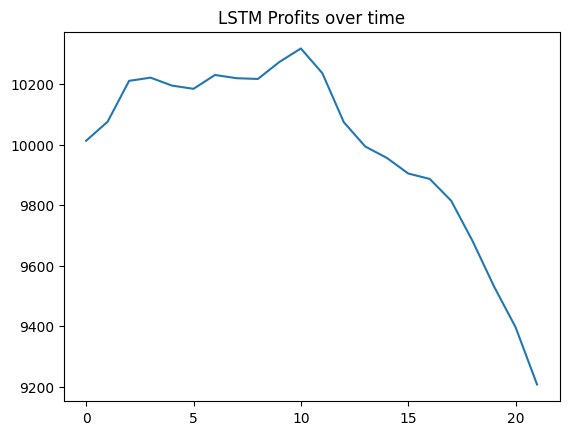

In [122]:
plt.plot(accumulated_lstm_profits)
plt.title("LSTM Profits over time")

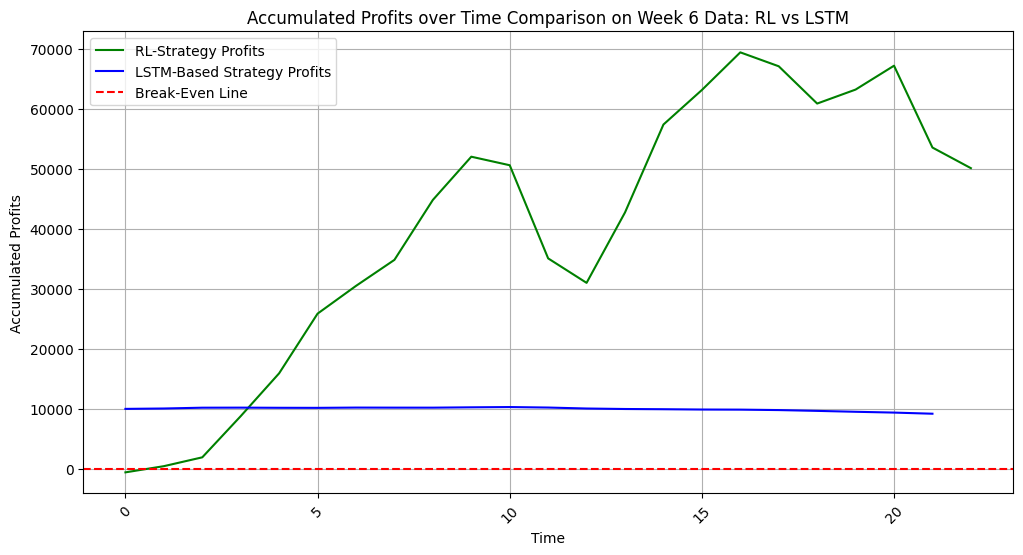

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(flattened_profits, label='RL-Strategy Profits', color='green')
plt.plot(accumulated_lstm_profits, label='LSTM-Based Strategy Profits', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Break-Even Line')
plt.xlabel('Time')
plt.ylabel('Accumulated Profits')
plt.title('Accumulated Profits over Time Comparison on Week 6 Data: RL vs LSTM')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()